In [1]:
# Code for Wyss Center ML Scientist task
# @ Gino Del Ferraro, NYU, June 2023

# Code number 1

In [2]:
# Plot all jupyter outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import numpy as np
np.set_printoptions(threshold=100)

import os
import scipy

import seaborn as sns

import matplotlib.pyplot as plt
import mne
from scipy import signal
from scipy.signal import iirnotch, lfilter

import scipy.signal as sig
import scipy.stats.distributions as dist


In [4]:
# Session number
sess = 1

In [5]:
"""
Sample code for loading data

Event names and values:
REST = 100
MOVE1 = 184
MOVE2 = 185

"raw" contains the standard MNE Raw oject with header and data.
"events" contains a list of [sample index, 0 (ignore), event ID].
For example, the subject performed MOVE2 action at 12.5s since the beginning of the recording.

Note:
You are free to use any library of your choice instead of MNE.

"""

dir_data = '../Data/'

if __name__ == '__main__':
#     fif_file = './session0.fif'
    fif_file = os.path.join(dir_data, './session{}.fif'.format(sess))
    print(fif_file)
    raw = mne.io.Raw(fif_file, preload=True, verbose='error')
    events = mne.find_events(raw, stim_channel='TRIGGER', shortest_event=1,
        uint_cast=True, consecutive='increasing', output='onset', initial_event=True)
    print('Sampling frequency: %.2f Hz' % raw.info['sfreq'])
    print('Channels:', raw.ch_names)
    print(events)

'\nSample code for loading data\n\nEvent names and values:\nREST = 100\nMOVE1 = 184\nMOVE2 = 185\n\n"raw" contains the standard MNE Raw oject with header and data.\n"events" contains a list of [sample index, 0 (ignore), event ID].\nFor example, the subject performed MOVE2 action at 12.5s since the beginning of the recording.\n\nNote:\nYou are free to use any library of your choice instead of MNE.\n\n'

../Data/./session1.fif
45 events found
Event IDs: [100 184 185 216]
Sampling frequency: 1024.00 Hz
Channels: ['TRIGGER', 'R1', 'R2', 'R3', 'L1', 'L2', 'L3']
[[ 10240      0    100]
 [ 12800      0    184]
 [ 23401      0    216]
 ...
 [274666      0    100]
 [277226      0    184]
 [291511      0    216]]


### Band pass filter on raw data + notch filter at 50Hz

In [6]:
# Apply bandpass filter
raw.filter(l_freq=1, h_freq=300)

# Apply notch filter at 50 Hz
freqs = (50,)
raw.notch_filter(freqs=freqs)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 300.00 Hz
- Upper transition bandwidth: 75.00 Hz (-6 dB cutoff frequency: 337.50 Hz)
- Filter length: 3381 samples (3.302 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s finished


<Raw | session1.fif, 7 x 292921 (286.1 s), ~15.7 MB, data loaded>

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 6759 samples (6.601 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s finished


<Raw | session1.fif, 7 x 292921 (286.1 s), ~15.7 MB, data loaded>

## Get mne-filtered data

In [7]:
dataF = raw.get_data()
dataF.shape

(7, 292921)

### Separate time series array and event channel

In [8]:
print(dataF.shape)
dataF_ts = dataF[1:,:]
print(dataF_ts.shape)
event = dataF[0,:]
print(event.shape)

(7, 292921)
(6, 292921)
(292921,)


In [9]:
sampling = 1/1024
# length of time data in sec.
dataF.shape[1]*sampling
# length of time data in min
print(f"time series length in sec: {dataF.shape[1]*sampling/60}")

286.0556640625

time series length in sec: 4.767594401041666


In [10]:
def find_matching_values(array, matching_array):
    matching_indices = np.isin(array, matching_array)
    matching_values = array[matching_indices]
    matching_indices = np.where(matching_indices)[0]
    return matching_indices, matching_values

In [11]:
idx, values =  find_matching_values(event, [100,184,185])
idx, values

(array([ 10240,  12800,  25124,  27684,  42369,  44929,  60513,  63073,
         87861,  90421, 100436, 102996, 119510, 122070, 135662, 138222,
        155871, 158431, 172038, 174598, 201188, 203748, 218338, 220898,
        238561, 241121, 258379, 260939, 274666, 277226]),
 array([100., 184., 100., 185., 100., 185., 100., 185., 100., 184., 100.,
        185., 100., 184., 100., 185., 100., 184., 100., 185., 100., 184.,
        100., 185., 100., 184., 100., 184., 100., 184.]))

In [12]:
## Number of events for this session 

In [13]:
count = np.count_nonzero(values == 100) # Rest
count
count = np.count_nonzero(values == 184) # M1
count
count = np.count_nonzero(values == 185) # M2
count

15

8

7

### Plot time series function

In [14]:
sns.set_theme()

def plot_time_series(data, title='', sampling=1024, color='green', f_size=(20, 5)):

    fig, ax = plt.subplots(1,1, figsize=f_size)

    ax.set_facecolor((0.9,0.9,0.9,0.2))
    
    # Plot the time series
    ax.plot(data, color)
    ax.set_xlabel('Time steps', fontsize=14, labelpad=10)
    ax.set_ylabel('Value', fontsize=14, labelpad=10)
    ax.set_title(title, fontsize=17, pad=7)
    
    ax.tick_params(axis='both', which='major', labelsize=12)

    ax.grid(True, linestyle='-', alpha=0.6)

    # Show the plot
    # plt.show()
    return fig

## PLOT time series

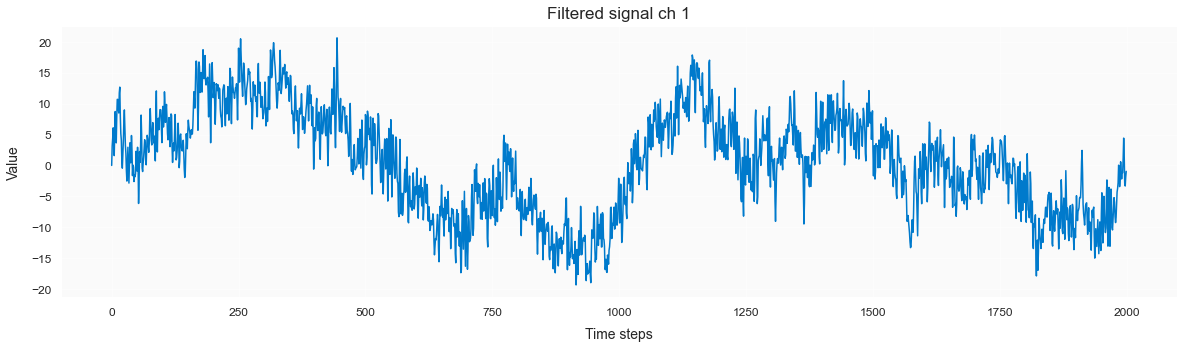

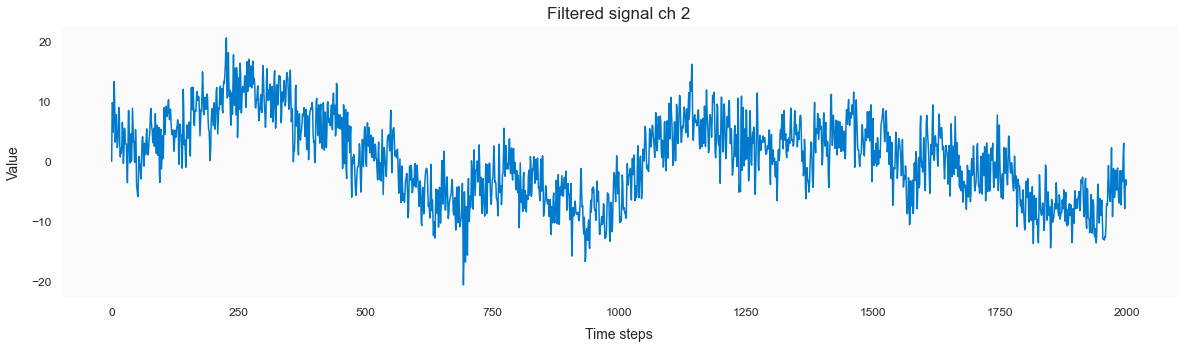

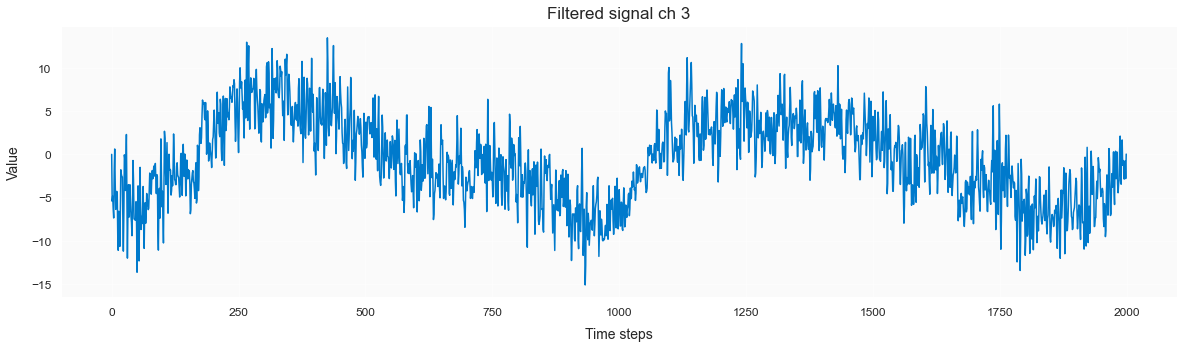

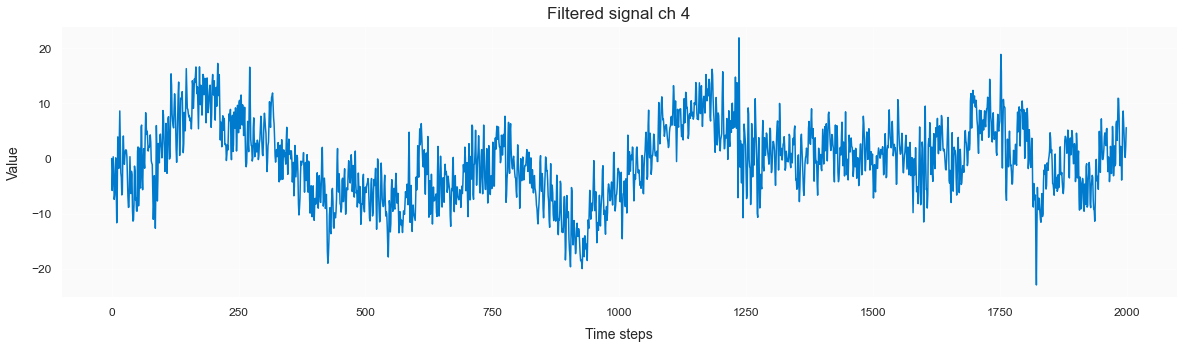

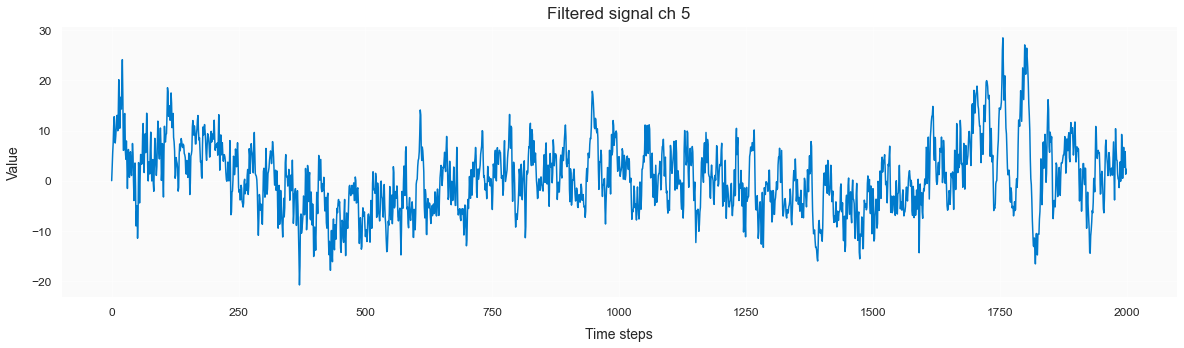

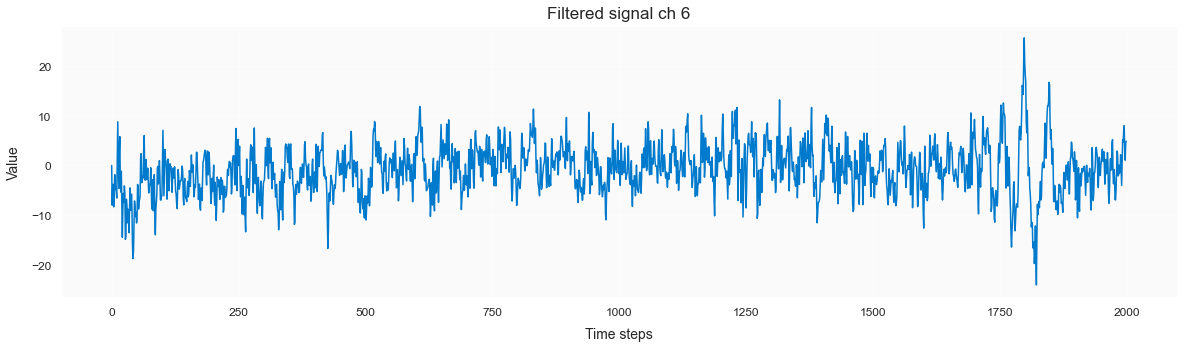

In [15]:
start = 0 # starting point for time series plot
finish = 2000 # ending point 

fig_path = '../Figures/'

for i in range(0,6):

    fig = plot_time_series(dataF_ts[i,start:finish],'Filtered signal ch {}'.format(i+1),color='#007acc')    

### Extract events from full time series: R, M1, M2

In [16]:
def extract_events(timeseries,event,sampling=1024):

    # event codes
    R = 100
    M1 = 184
    M2 = 185

    # durations for each event
    len_R = int(2.5*sampling)
    len_M1 = int(5*sampling) 
    len_M2 = int(5*sampling) 

    # find the indices where each event starts
    R_indices = np.where(event == R)[0]
    M1_indices = np.where(event == M1)[0]
    M2_indices = np.where(event == M2)[0]

    print("N. of Rest: {} \nN. of M1: {}\nN. of M2: {}\ntotal: {}".format(len(R_indices),len(M1_indices),len(M2_indices),len(R_indices)+len(M1_indices)+len(M2_indices)))

    # for each index, select the corresponding slice from timeseries
    R_timeseries = np.array([timeseries[:, i:i+len_R] for i in R_indices])
    M1_timeseries = np.array([timeseries[:, i:i+len_M1] for i in M1_indices])
    M2_timeseries = np.array([timeseries[:, i:i+len_M2] for i in M2_indices])

    # dimensions are (number of events, number of channels, event length)
    # Swap the first two dimensions to get to (number of channels, number of events, event length)
    R_timeseries = np.swapaxes(R_timeseries, 0, 1)
    M1_timeseries = np.swapaxes(M1_timeseries, 0, 1)
    M2_timeseries = np.swapaxes(M2_timeseries, 0, 1)

    return R_timeseries, M1_timeseries, M2_timeseries, R_indices, M1_indices, M2_indices

### Get events

In [17]:
R_tsF, M1_tsF, M2_tsF, R_ind, M1_ind, M2_ind = extract_events(dataF_ts,event,sampling=1024)
R_tsF.shape, M1_tsF.shape, M2_tsF.shape

N. of Rest: 15 
N. of M1: 8
N. of M2: 7
total: 30


((6, 15, 2560), (6, 8, 5120), (6, 7, 5120))

In [18]:
### Check for NaN values
print("Nan values:\nR = {}\nM1 = {}\nM2 ={}".format( np.sum(np.isnan(R_tsF)),np.sum(np.isnan(M1_tsF)),np.sum(np.isnan(M2_tsF))  ))

Nan values:
R = 0
M1 = 0
M2 =0


### Split Movement trials into first half and second half

In [19]:
# Shapes before splitting
R_tsF.shape
M1_tsF.shape
M2_tsF.shape

(6, 15, 2560)

(6, 8, 5120)

(6, 7, 5120)

### Splitting function

In [20]:
def split_time_dim(movement):
    ch, trials, time = movement.shape
    midpoint = time // 2  # Compute the midpoint in the time dimension

    # Split the array
    first_half = movement[:, :, :midpoint]
    second_half = movement[:, :, midpoint:]

    return first_half, second_half

### Make sure to merge first and second half of movements one after the other in the trial dimension. 
This is important not to mix first half trial and second half between training and test set

In [21]:
def merge_arrays_alternatively(arr1, arr2):
    
    # Check if the input arrays have the same shape
    assert arr1.shape == arr2.shape, "The input arrays must have the same shape"

    ch, trials, time = arr1.shape

    # Reshape the arrays to merge them alternatively
    arr1 = arr1.reshape(ch, trials, time, 1)
    arr2 = arr2.reshape(ch, trials, time, 1)

    # Stack arrays along the new third axis
    arr = np.dstack((arr1, arr2)).reshape(ch, trials*2, time)

    return arr


In [22]:
r_split = R_tsF # there is no split in rest trials 

# Split M1 and merge in the trial direction 
first, second = split_time_dim(M1_tsF) 
m1_split = merge_arrays_alternatively(first, second)

# Split M2 and merge in the trial direction
first, second = split_time_dim(M2_tsF)
m2_split = merge_arrays_alternatively(first, second)

# print new shapes
r_split.shape
m1_split.shape
m2_split.shape

(6, 15, 2560)

(6, 16, 2560)

(6, 14, 2560)

### Check visually that the merging works as expected 

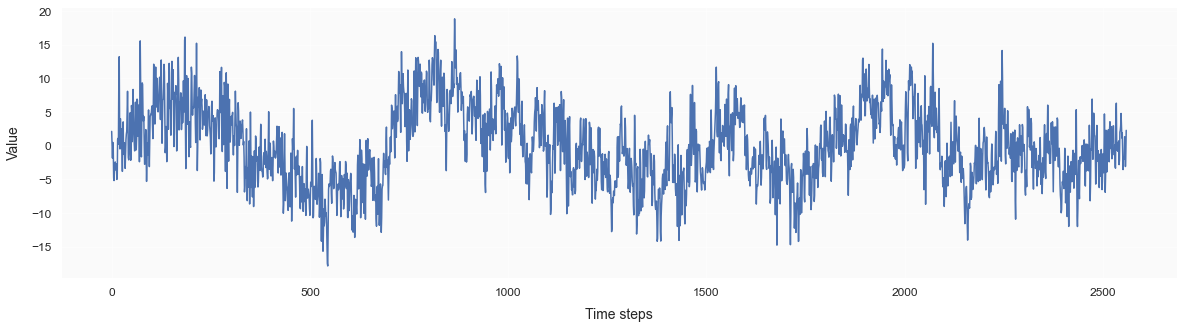

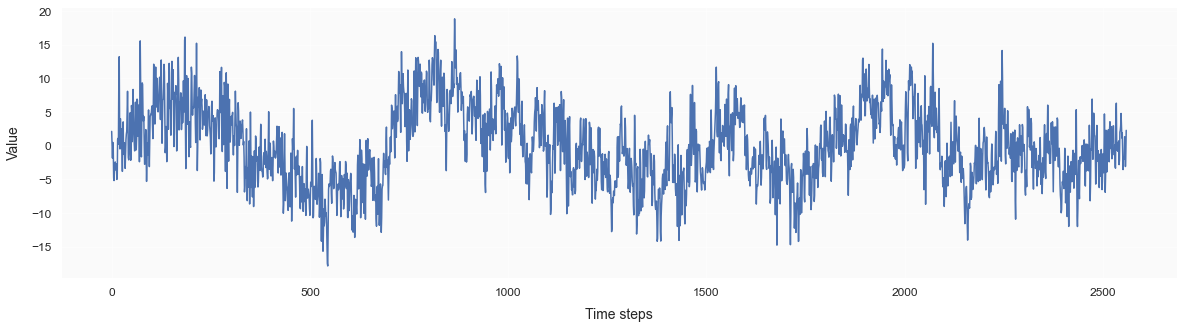

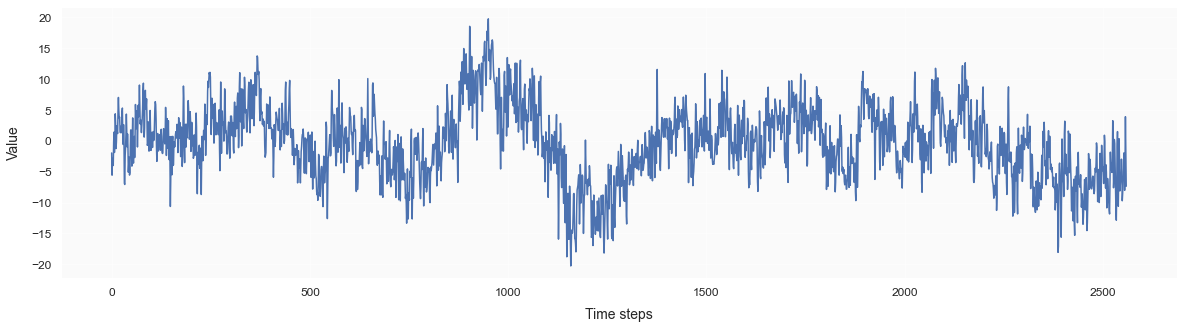

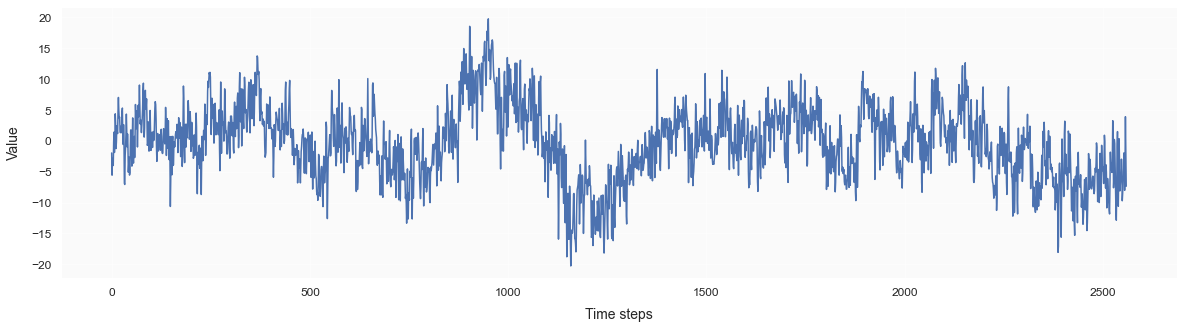

In [23]:
start = 0
finish = 2560 # max time points for each event

plot_time_series(M1_tsF[0,0,start:finish],color='b'); # First half from M1 (5 sec.)
plot_time_series(m1_split[0,0,start:finish],color='b'); # First half after split

plot_time_series(M1_tsF[0,0,finish:2*finish],color='b'); # Second half from M1 (5 sec.)
plot_time_series(m1_split[0,1,start:finish],color='b'); # Second half after split

### Trial average, for each channel

In [24]:
m1_split.shape

(6, 16, 2560)

In [25]:
R_ch = np.mean(r_split,axis = 1)
M1_ch = np.mean(m1_split,axis = 1)
M2_ch = np.mean(m2_split,axis = 1)
R_ch.shape

(6, 2560)

### Channel average, trial average, for a given session

In [26]:
R_sess = np.mean(R_ch,axis = 0)
M1_sess = np.mean(M1_ch,axis = 0)
M2_sess = np.mean(M2_ch,axis = 0)
R_sess.shape

(2560,)

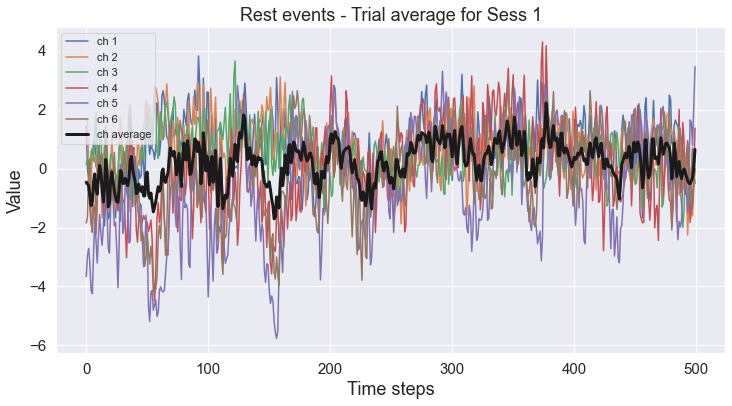

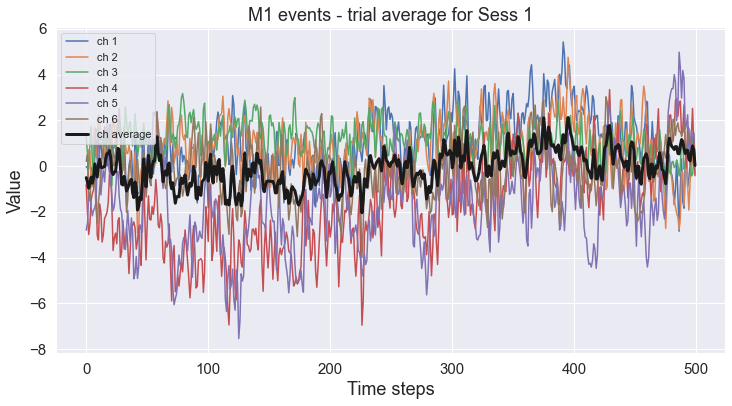

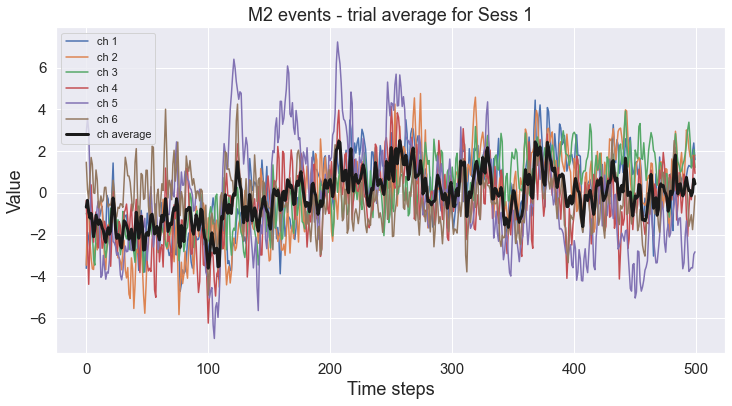

In [27]:
InteractiveShell.ast_node_interactivity = "last"

# start and finish for visualization 
start = 0
finish = 500

a = 12
b = 6


# REST 

plt.figure(figsize=(a, b))  

for ch in range(0,6):
    plt.plot(R_ch[ch,start:finish],label = 'ch {}'.format(ch+1))
plt.plot(R_sess[start:finish],'k',linewidth=3, label ='ch average')

plt.xlabel('Time steps',fontsize=18)
plt.ylabel('Value',fontsize=18)
plt.title('Rest events - Trial average for Sess {}'.format(sess),fontsize=18)
plt.legend(loc='upper left')

plt.tick_params(axis='both', labelsize=15)
plt.show();


# M1 

plt.figure(figsize=(a, b)) 

for ch in range(0,6):
    plt.plot(M1_ch[ch,start:finish],label = 'ch {}'.format(ch+1))
plt.plot(M1_sess[start:finish],'k',linewidth=3, label ='ch average')

plt.xlabel('Time steps',fontsize=18)
plt.ylabel('Value',fontsize=18)
plt.title('M1 events - trial average for Sess {}'.format(sess),fontsize=18)
plt.legend(loc='upper left')

plt.tick_params(axis='both', labelsize=15)
plt.show();

# # M2 

plt.figure(figsize=(a, b))  

for ch in range(0,6):
    plt.plot(M2_ch[ch,start:finish],label = 'ch {}'.format(ch+1))
plt.plot(M2_sess[start:finish],'k',linewidth=3, label ='ch average')

plt.xlabel('Time steps',fontsize=18)
plt.ylabel('Value',fontsize=18)
plt.title('M2 events - trial average for Sess {}'.format(sess),fontsize=18)
plt.legend(loc='upper left')

plt.tick_params(axis='both', labelsize=15)
plt.show();

## Save data to be loaded in matlab for Spectral Analysis

In [28]:
data_dir = '../Data/'

file_name = 'R_F_split_ord_sess_{}.mat'.format(sess) # Rest
data_path_name = os.path.join(data_dir,file_name)

# Create a dictionary to store the data
data_dict = {'RF': r_split}
scipy.io.savemat(data_path_name, data_dict) # matlab files

file_name = 'M1_F_split_ord_sess_{}.mat'.format(sess) # M1
data_path_name = os.path.join(data_dir,file_name)

# Create a dictionary to store the data
data_dict = {'M1F': m1_split}
scipy.io.savemat(data_path_name, data_dict) # matlab files


file_name = 'M2_F_split_ord_sess_{}.mat'.format(sess) # M2
data_path_name = os.path.join(data_dir,file_name)

# Create a dictionary to store the data
data_dict = {'M2F': m2_split}
scipy.io.savemat(data_path_name, data_dict) # matlab files